# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    target_row, target_col = qmaze.target
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[target_row, target_col] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down.

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The following code will be the setup for the function to generate a randomized maze. There are several variables that will be set here to help standardize the maze generation.

In [5]:
MAZE_WIDTH = 8
MAZE_HEIGHT = 8
# This is the probability that any single cell will be a wall, 
# the probability is out of 100, so there is a WALL_CHANCE out of 100 that an individual cell is a wall
WALL_CHANCE = 33 
DEFAULT_PIRATE_POSITION = (0, 0)

This is the main function that will generate the randomized maze.

In [6]:
def generate_maze():
    # Randomly generate the array of values
    maze_values = np.ones((MAZE_WIDTH, MAZE_HEIGHT))
    i = 0
    while i < len(maze_values):
        j = 0
        while j < len(maze_values):
            chance = random.randint(1, 100)
            if chance <= WALL_CHANCE:
                maze_values[i][j] = 0
            j += 1
        i += 1

    # Randomly generate the target location
    x = random.randint(0, MAZE_WIDTH - 1)
    y = random.randint(0, MAZE_HEIGHT - 1)
    target_location = (x, y)
    
    # Ensure that the default pirate position and the target position are unblocked
    maze_values[target_location[0]][target_location[1]] = 1
    maze_values[DEFAULT_PIRATE_POSITION[0]][DEFAULT_PIRATE_POSITION[1]] = 1

    # Create the TreasureMaze Object to test pathing in the maze
    maze = TreasureMaze(maze_values, target_location)
    
    # Check each cell and determine if there is a valid path to the target
    free_cells = maze.free_cells
    visited = [] # Holds cells that have been visited to avoid repeat calculations
    next_cell_que = [] # Holds the cells we plan to visit
    for cell in free_cells:
        # If its been visited, we know there is no need to check again
        if cell in visited:
            continue
        # Begin the que
        visited.append(cell)
        next_cell_que.append(cell)

        # While the queue is not empty, continuing searching and adding new cells to travel to until you reach the target cell
        while len(next_cell_que) != 0:
            # Pop the next item
            next_cell = next_cell_que.pop(0)
            visited.append(next_cell)
            valid_moves = maze.valid_actions(next_cell) 
            # Add the valid moves to the queue to be checked next
            for move in valid_moves:
                check_next = None
                if move == LEFT:
                    check_next = (next_cell[0], next_cell[1] - 1)
                elif move == UP:
                    check_next = (next_cell[0] - 1, next_cell[1])
                elif move == RIGHT:
                    check_next = (next_cell[0], next_cell[1] + 1)
                elif move == DOWN:
                    check_next = (next_cell[0] + 1, next_cell[1])

                # Only add this cell if it hasn't been checked before and is not currently in the que
                if (check_next not in visited) and (check_next not in next_cell_que):
                    next_cell_que.append(check_next)
            
            # If the que is empty, then there were no valid new moves to add, there is a wall blocking the path
            # Find and destroy the wall, then add that cell to the que
            if len(next_cell_que) == 0:
                # Arbitrarily start by searching right, left, up then down
                # Search until the right edge is found or a wall
                search_cell = (next_cell[0], next_cell[1] + 1)
                while search_cell[1] < MAZE_WIDTH:
                    # Wall found, destroy and add this cell to the que
                    if maze_values[search_cell[0]][search_cell[1]] == 0:
                        maze_values[search_cell[0]][search_cell[1]] = 1
                        next_cell_que.append(search_cell)
                        break
                    search_cell = (search_cell[0], search_cell[1] + 1)

                # Assuming a valid wall was found, continue testing the maze
                if len(next_cell_que) == 1:
                    continue
                    
                # Search until the left edge is found or a wall
                search_cell = (next_cell[0], next_cell[1] - 1)
                while search_cell[1] >= 0:
                    # Wall found, destroy and add this cell to the que
                    if maze_values[search_cell[0]][search_cell[1]] == 0:
                        maze_values[search_cell[0]][search_cell[1]] = 1
                        next_cell_que.append(search_cell)
                        break
                    search_cell = (search_cell[0], search_cell[1] - 1)

                # Assuming a valid wall was found, continue testing the maze
                if len(next_cell_que) == 1:
                    continue

                # Search until the upper edge is found or a wall
                search_cell = (next_cell[0] - 1, next_cell[1])
                while search_cell[0] >= 0:
                    # Wall found, destroy and add this cell to the que
                    if maze_values[search_cell[0]][search_cell[1]] == 0:
                        maze_values[search_cell[0]][search_cell[1]] = 1
                        next_cell_que.append(search_cell)
                        break
                    search_cell = (search_cell[0] - 1, search_cell[1])


                # Assuming a valid wall was found, continue testing the maze
                if len(next_cell_que) == 1:
                    continue
                    
                # Search until the bottom edge is found or a wall
                search_cell = (next_cell[0] + 1, next_cell[1])
                while search_cell[0] < MAZE_HEIGHT:
                    # Wall found, destroy and add this cell to the que
                    if maze_values[search_cell[0]][search_cell[1]] == 0:
                        maze_values[search_cell[0]][search_cell[1]] = 1
                        next_cell_que.append(search_cell)
                        break
                    search_cell = (search_cell[0] + 1, search_cell[1])

            # When the goal is in the que, we know that each cell that has been visited or that is now in the que is able to reach the goal
            # Therefore there is no need to check any of them further
            if target_location in next_cell_que:
                # Remove the goal from the que - we want this to be added again for other cells
                next_cell_que.remove(target_location)
                # Add the remaining cells to the visited list
                visited.extend(next_cell_que)
                next_cell_que = []
                
    # Finally, regenerate the maze with the validated paths
    maze = TreasureMaze(maze_values, target_location)
    return maze

The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


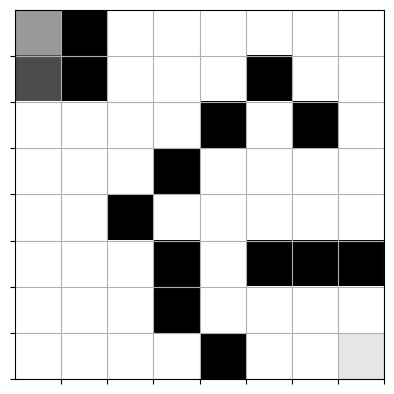

In [7]:
qmaze = TreasureMaze(maze, (MAZE_WIDTH - 1, MAZE_HEIGHT - 1))
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [8]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [9]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [10]:
def build_model(maze):
    model = Sequential()
    model.add(Input(shape=(maze.size,)))
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [11]:
def qtrain(model, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    # Creates a randomized yet valid maze to complete
    qmaze = generate_maze()
    print("Maze 1:")
    plt.show(show(qmaze))
    # This is the number of times the agent is allowed to try a maze before it is randomized again
    maze_attempts = 10
    free_cells = qmaze.free_cells

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    attempts = 0
    mazes = 2
    for epoch in range(n_epoch):
        attempts += 1
        # Determine if it is time to randomize the maze again
        if attempts >= maze_attempts:
            qmaze = generate_maze()
            print("Maze " + str(mazes) + ":")
            plt.show(show(qmaze))
            mazes += 1
            free_cells = qmaze.free_cells
            attempts = 0
        #    Agent_cell = randomly select a free cell
        agent_cell = random.choice(free_cells)
        loss = 0.0
        n_episodes = 0
        #    Reset the maze with agent set to above position
        #    Hint: Review the reset method in the TreasureMaze.py class.
        qmaze.reset(agent_cell)
        #    envstate = Environment.current_state
        #    Hint: Review the observe method in the TreasureMaze.py class.
        envstate = qmaze.observe()
        #    While state is not game over:
    
        while qmaze.game_status() == 'not_over':
            #        previous_envstate = envstate
            #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
            #        envstate, reward, game_status = qmaze.act(action)
            #    Hint: Review the act method in the TreasureMaze.py class.
            previous_envstate = envstate
            action = -1
            action_space = qmaze.valid_actions()
            # Explore
            if np.random.rand() < epsilon:
                action = random.choice(action_space)
            # Exploitation
            else:
                q_values = model.predict(envstate, verbose=0)
                action = np.argmax(q_values[0])
            envstate, reward, game_status = qmaze.act(action)
            #        episode = [previous_envstate, action, reward, envstate, game_status]
            #        Store episode in Experience replay object
            #    Hint: Review the remember method in the GameExperience.py class.
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            n_episodes += 1
            if (qmaze.game_status() == 'lose'):
                win_history.append(0)
            elif (qmaze.game_status() == 'win'):
                win_history.append(1)
            #        Train neural network model and evaluate loss
            #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
            input_data, target = experience.get_data()
            model.fit(input_data, target, verbose=0)
            #          to train the model. You can call model.evaluate to determine loss.
            loss = model.evaluate(input_data, target, verbose=0)
        #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.    
        #Print the epoch, loss, episodes, win count, and win rate for each epoch
        if (len(win_history) != 0):
            win_rate = sum(win_history) / len(win_history)
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

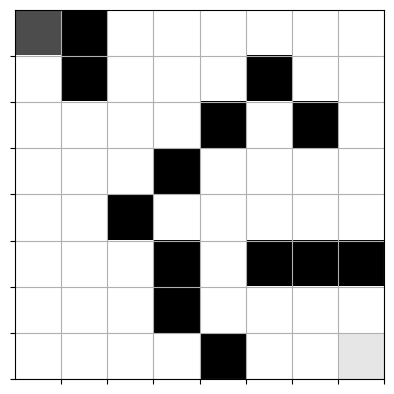

In [12]:
qmaze = TreasureMaze(maze, (MAZE_WIDTH - 1, MAZE_HEIGHT - 1))
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

Maze 1:


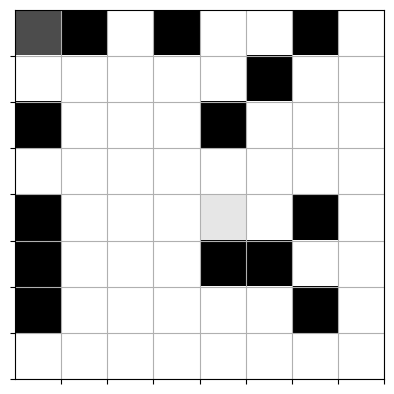

Epoch: 000/14999 | Loss: 0.0060 | Episodes: 49 | Win count: 0 | Win rate: 0.000 | time: 40.3 seconds
Epoch: 001/14999 | Loss: 0.0208 | Episodes: 66 | Win count: 0 | Win rate: 0.000 | time: 98.0 seconds
Epoch: 002/14999 | Loss: 0.0131 | Episodes: 47 | Win count: 0 | Win rate: 0.000 | time: 138.7 seconds
Epoch: 003/14999 | Loss: 0.0217 | Episodes: 54 | Win count: 0 | Win rate: 0.000 | time: 185.7 seconds
Epoch: 004/14999 | Loss: 0.0239 | Episodes: 57 | Win count: 0 | Win rate: 0.000 | time: 235.5 seconds
Epoch: 005/14999 | Loss: 0.0119 | Episodes: 72 | Win count: 0 | Win rate: 0.000 | time: 298.7 seconds
Epoch: 006/14999 | Loss: 0.0238 | Episodes: 60 | Win count: 0 | Win rate: 0.000 | time: 351.2 seconds
Epoch: 007/14999 | Loss: 0.0149 | Episodes: 57 | Win count: 0 | Win rate: 0.000 | time: 6.67 minutes
Epoch: 008/14999 | Loss: 0.0227 | Episodes: 1 | Win count: 1 | Win rate: 0.111 | time: 6.69 minutes
Maze 2:


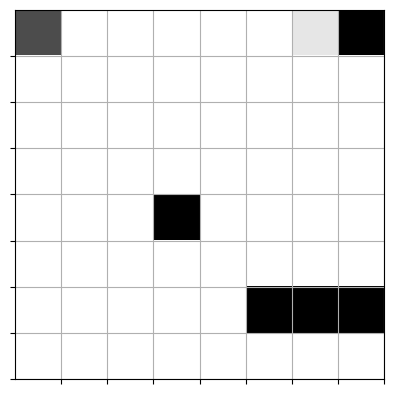

Epoch: 009/14999 | Loss: 0.0155 | Episodes: 60 | Win count: 1 | Win rate: 0.100 | time: 7.57 minutes
Epoch: 010/14999 | Loss: 0.0209 | Episodes: 78 | Win count: 1 | Win rate: 0.091 | time: 8.70 minutes
Epoch: 011/14999 | Loss: 0.0220 | Episodes: 55 | Win count: 1 | Win rate: 0.083 | time: 9.50 minutes
Epoch: 012/14999 | Loss: 0.0150 | Episodes: 57 | Win count: 1 | Win rate: 0.077 | time: 10.33 minutes
Epoch: 013/14999 | Loss: 0.0252 | Episodes: 65 | Win count: 2 | Win rate: 0.143 | time: 11.67 minutes
Epoch: 014/14999 | Loss: 0.0264 | Episodes: 53 | Win count: 3 | Win rate: 0.200 | time: 13.14 minutes
Epoch: 015/14999 | Loss: 0.0207 | Episodes: 75 | Win count: 3 | Win rate: 0.188 | time: 15.26 minutes
Epoch: 016/14999 | Loss: 0.0231 | Episodes: 38 | Win count: 4 | Win rate: 0.235 | time: 16.28 minutes
Epoch: 017/14999 | Loss: 0.0238 | Episodes: 33 | Win count: 5 | Win rate: 0.278 | time: 17.17 minutes
Epoch: 018/14999 | Loss: 0.0263 | Episodes: 58 | Win count: 6 | Win rate: 0.316 | tim

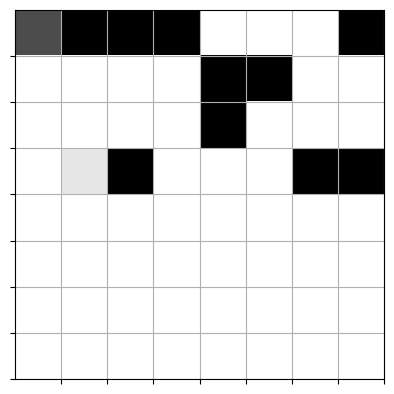

Epoch: 019/14999 | Loss: 0.0211 | Episodes: 67 | Win count: 6 | Win rate: 0.300 | time: 20.66 minutes
Epoch: 020/14999 | Loss: 0.0714 | Episodes: 80 | Win count: 6 | Win rate: 0.286 | time: 22.74 minutes
Epoch: 021/14999 | Loss: 0.0739 | Episodes: 85 | Win count: 6 | Win rate: 0.273 | time: 24.95 minutes
Epoch: 022/14999 | Loss: 0.0275 | Episodes: 7 | Win count: 7 | Win rate: 0.304 | time: 25.13 minutes
Epoch: 023/14999 | Loss: 0.0203 | Episodes: 77 | Win count: 7 | Win rate: 0.292 | time: 27.16 minutes
Epoch: 024/14999 | Loss: 0.0207 | Episodes: 25 | Win count: 8 | Win rate: 0.320 | time: 27.83 minutes
Epoch: 025/14999 | Loss: 0.0238 | Episodes: 51 | Win count: 9 | Win rate: 0.346 | time: 29.30 minutes
Epoch: 026/14999 | Loss: 0.0178 | Episodes: 67 | Win count: 9 | Win rate: 0.333 | time: 31.22 minutes
Epoch: 027/14999 | Loss: 0.0549 | Episodes: 2 | Win count: 10 | Win rate: 0.357 | time: 31.28 minutes
Epoch: 028/14999 | Loss: 0.0139 | Episodes: 41 | Win count: 11 | Win rate: 0.379 | 

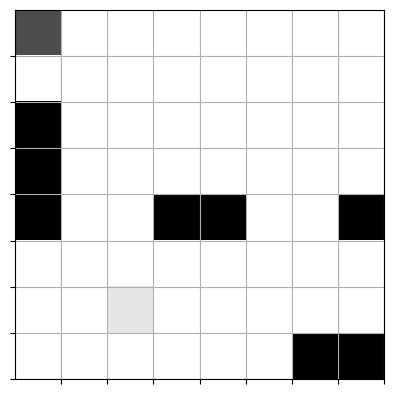

Epoch: 029/14999 | Loss: 0.0255 | Episodes: 47 | Win count: 12 | Win rate: 0.400 | time: 33.74 minutes
Epoch: 030/14999 | Loss: 0.0184 | Episodes: 65 | Win count: 12 | Win rate: 0.387 | time: 35.63 minutes
Epoch: 031/14999 | Loss: 0.0139 | Episodes: 6 | Win count: 13 | Win rate: 0.406 | time: 35.79 minutes
Epoch: 032/14999 | Loss: 0.0172 | Episodes: 11 | Win count: 14 | Win rate: 0.424 | time: 36.06 minutes
Epoch: 033/14999 | Loss: 0.0186 | Episodes: 13 | Win count: 15 | Win rate: 0.441 | time: 36.25 minutes
Epoch: 034/14999 | Loss: 0.0206 | Episodes: 54 | Win count: 15 | Win rate: 0.429 | time: 37.05 minutes
Epoch: 035/14999 | Loss: 0.1151 | Episodes: 80 | Win count: 15 | Win rate: 0.417 | time: 38.23 minutes
Epoch: 036/14999 | Loss: 0.0208 | Episodes: 82 | Win count: 15 | Win rate: 0.405 | time: 39.46 minutes
Epoch: 037/14999 | Loss: 0.0231 | Episodes: 68 | Win count: 15 | Win rate: 0.395 | time: 40.46 minutes
Epoch: 038/14999 | Loss: 0.0346 | Episodes: 73 | Win count: 16 | Win rate:

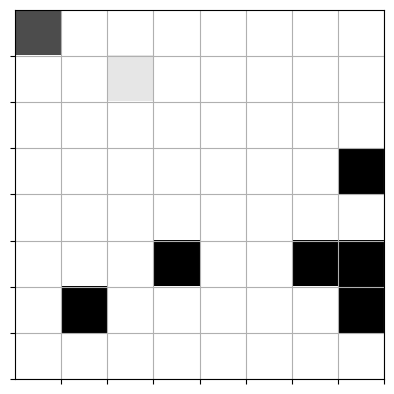

Epoch: 039/14999 | Loss: 0.0628 | Episodes: 16 | Win count: 17 | Win rate: 0.425 | time: 41.82 minutes


In [ ]:
model = build_model(maze)
qtrain(model, epochs=1000, max_memory=8*maze.size, data_size=32)

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.